<a href="https://colab.research.google.com/github/agadhiya/Potato_disease_Classification/blob/main/Potato_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Potato Leaf Disease Classification**

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

# Step 1: Import all the Dependencies


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Step 2: Import data into tensorflow dataset object

In [ ]:
from google.colab import files

# Upload the zipped folder
uploaded = files.upload()

Saving PlantVillage.zip to PlantVillage.zip


In [ ]:
import zipfile
import os

# Entpacke die ZIP-Datei (z.B. "PlantVillage.zip")
with zipfile.ZipFile("PlantVillage.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Überprüfe den Inhalt des Verzeichnisses
os.listdir('PlantVillage')

['Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight']

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 1 1 0 0 0 1 2 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1]


In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy())


[[[217. 210. 218.]
  [215. 208. 216.]
  [212. 205. 212.]
  ...
  [167. 158. 161.]
  [165. 156. 159.]
  [178. 169. 172.]]

 [[222. 215. 223.]
  [218. 211. 219.]
  [213. 206. 213.]
  ...
  [183. 174. 177.]
  [170. 161. 164.]
  [163. 154. 157.]]

 [[221. 214. 221.]
  [218. 211. 218.]
  [212. 205. 212.]
  ...
  [163. 154. 157.]
  [160. 151. 154.]
  [161. 152. 155.]]

 ...

 [[182. 176. 178.]
  [178. 172. 174.]
  [174. 168. 170.]
  ...
  [132. 126. 128.]
  [140. 134. 136.]
  [137. 131. 133.]]

 [[182. 176. 178.]
  [181. 175. 177.]
  [179. 173. 175.]
  ...
  [132. 126. 128.]
  [145. 139. 141.]
  [135. 129. 131.]]

 [[179. 173. 175.]
  [178. 172. 174.]
  [179. 173. 175.]
  ...
  [132. 126. 128.]
  [137. 131. 133.]
  [126. 120. 122.]]]


In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].shape)


(256, 256, 3)


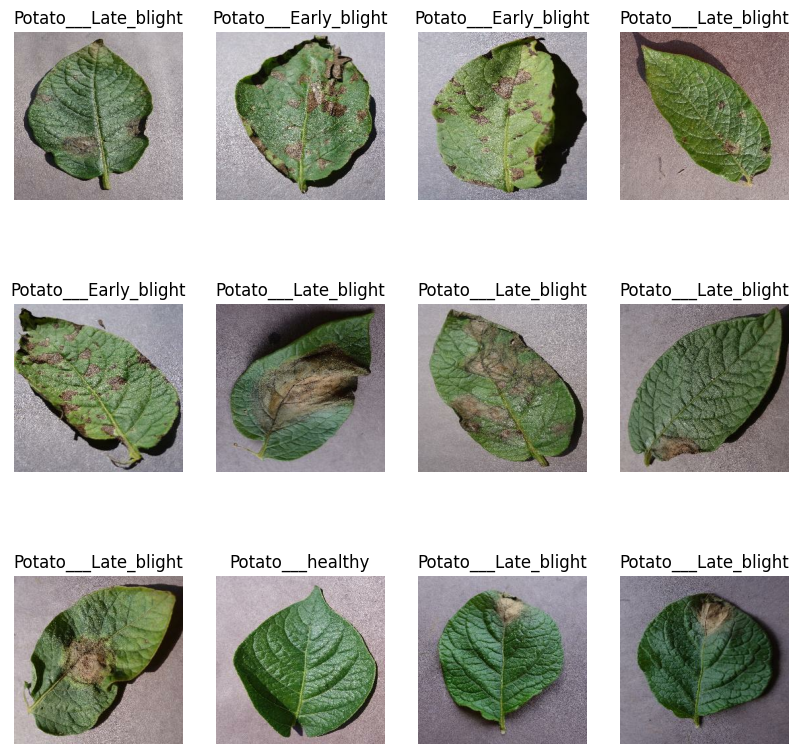

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

# Step 3: Split the dataset

80% --> training

20% --> 10% validation, 10% test

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)   # 20 %
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

To train the model fast

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Step 4: Building the Model

In [ ]:
from tensorflow.keras import layers, models

# Parameterdefinition
IMAGE_SIZE = 256  # Beispielbildgröße
CHANNELS = 3  # Anzahl der Farbkanäle
n_classes = 3  # Anzahl der Klassen

# Modell erstellen
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Eingabeform festlegen
    resize_and_rescale,  # Reskalierung und Resize (vorher definiert)
    data_augmentation,  # Datenaugmentation (vorher definiert)
    layers.Conv2D(32, (3, 3), activation='relu'),  # Erste Convolutional-Schicht
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # Umwandeln in 1D
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Modellübersicht anzeigen
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Modell ohne BATCH_SIZE bauen
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


# Step 5: Compiling the Model
- Used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 402ms/step - accuracy: 0.4822 - loss: 0.9488 - val_accuracy: 0.6719 - val_loss: 0.8688
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.6903 - loss: 0.7748 - val_accuracy: 0.7760 - val_loss: 0.5313
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - accuracy: 0.8048 - loss: 0.5068 - val_accuracy: 0.8229 - val_loss: 0.4285
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.8595 - loss: 0.3496 - val_accuracy: 0.8073 - val_loss: 0.6048
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 333ms/step - accuracy: 0.8335 - loss: 0.3972 - val_accuracy: 0.8490 - val_loss: 0.4583
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.8857 - loss: 0.2737 - val_accuracy: 0.8698 - val_loss: 0.3515
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 339ms/step - accuracy: 0.8973 - loss: 0.2436 - val_accuracy: 0.8542 - val_loss: 0.2981
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 353ms/step - accuracy: 0.8922 - loss: 0.2413 - val_accu

In [ ]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9552 - loss: 0.0762


In [ ]:
scores

[0.07210434228181839, 0.9609375]

# Step 6: Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy'] # accuracy

[0.5318287014961243,
 0.7152777910232544,
 0.8101851940155029,
 0.8518518805503845,
 0.8362268805503845,
 0.8940972089767456,
 0.8912037014961243,
 0.8854166865348816,
 0.9056712985038757,
 0.9299768805503845,
 0.9299768805503845,
 0.9236111044883728,
 0.9450231194496155,
 0.9421296119689941,
 0.9554398059844971,
 0.9450231194496155,
 0.9473379850387573,
 0.9571759104728699,
 0.9577546119689941,
 0.9623842835426331,
 0.9664351940155029,
 0.9820601940155029,
 0.9554398059844971,
 0.9820601940155029,
 0.9820601940155029,
 0.9652777910232544,
 0.9820601940155029,
 0.9884259104728699,
 0.9884259104728699,
 0.9924768805503845,
 0.9774305820465088,
 0.9901620149612427,
 0.9936342835426331,
 0.9606481194496155,
 0.9849537014961243,
 0.9878472089767456,
 0.9959490895271301,
 0.984375,
 0.9820601940155029,
 0.9866898059844971]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

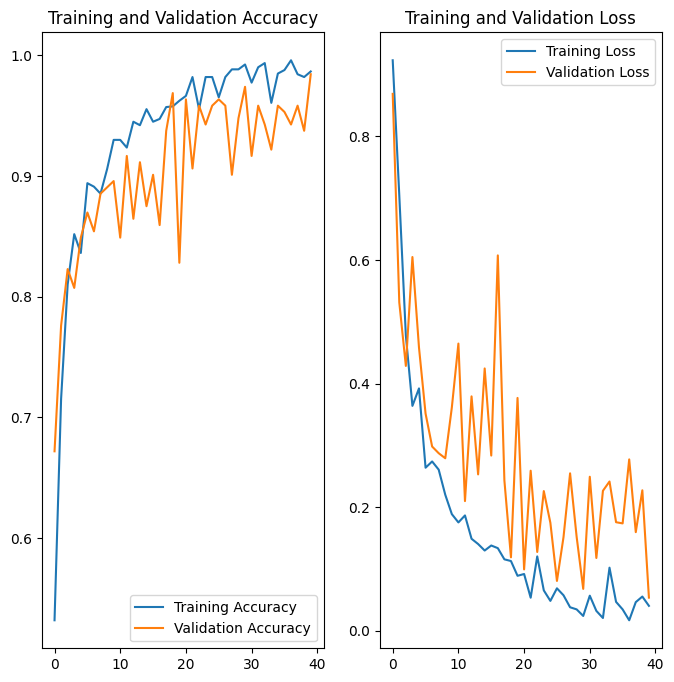

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Step 7: Run prediction on a sample image

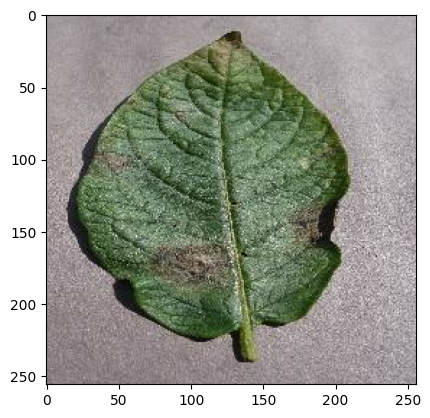

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))



first image to predict
first image's actual label: 0
Actual label: Potato___Early_blight


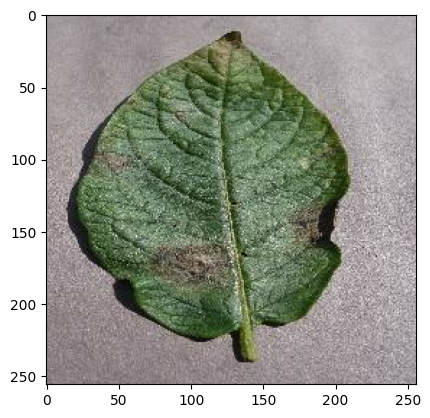

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", first_label)
  print("Actual label:", class_names[first_label])

first image to predict
Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted label: Potato___Late_blight


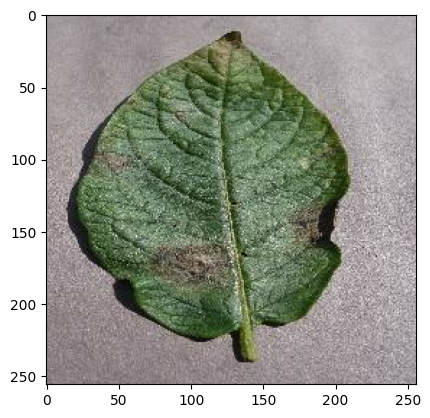

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("Actual label:", class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

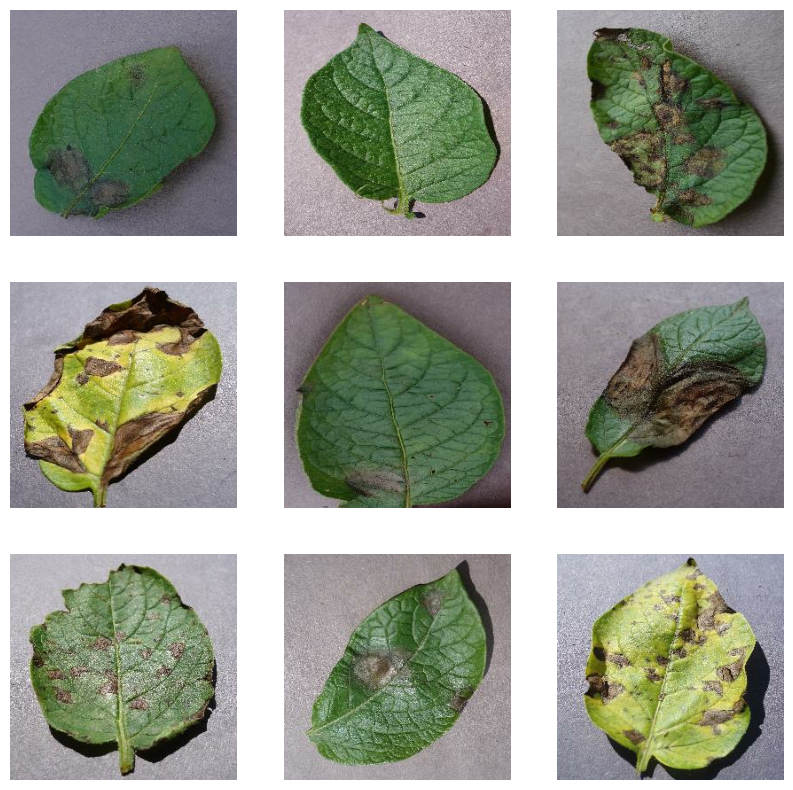

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Step 8: Now run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


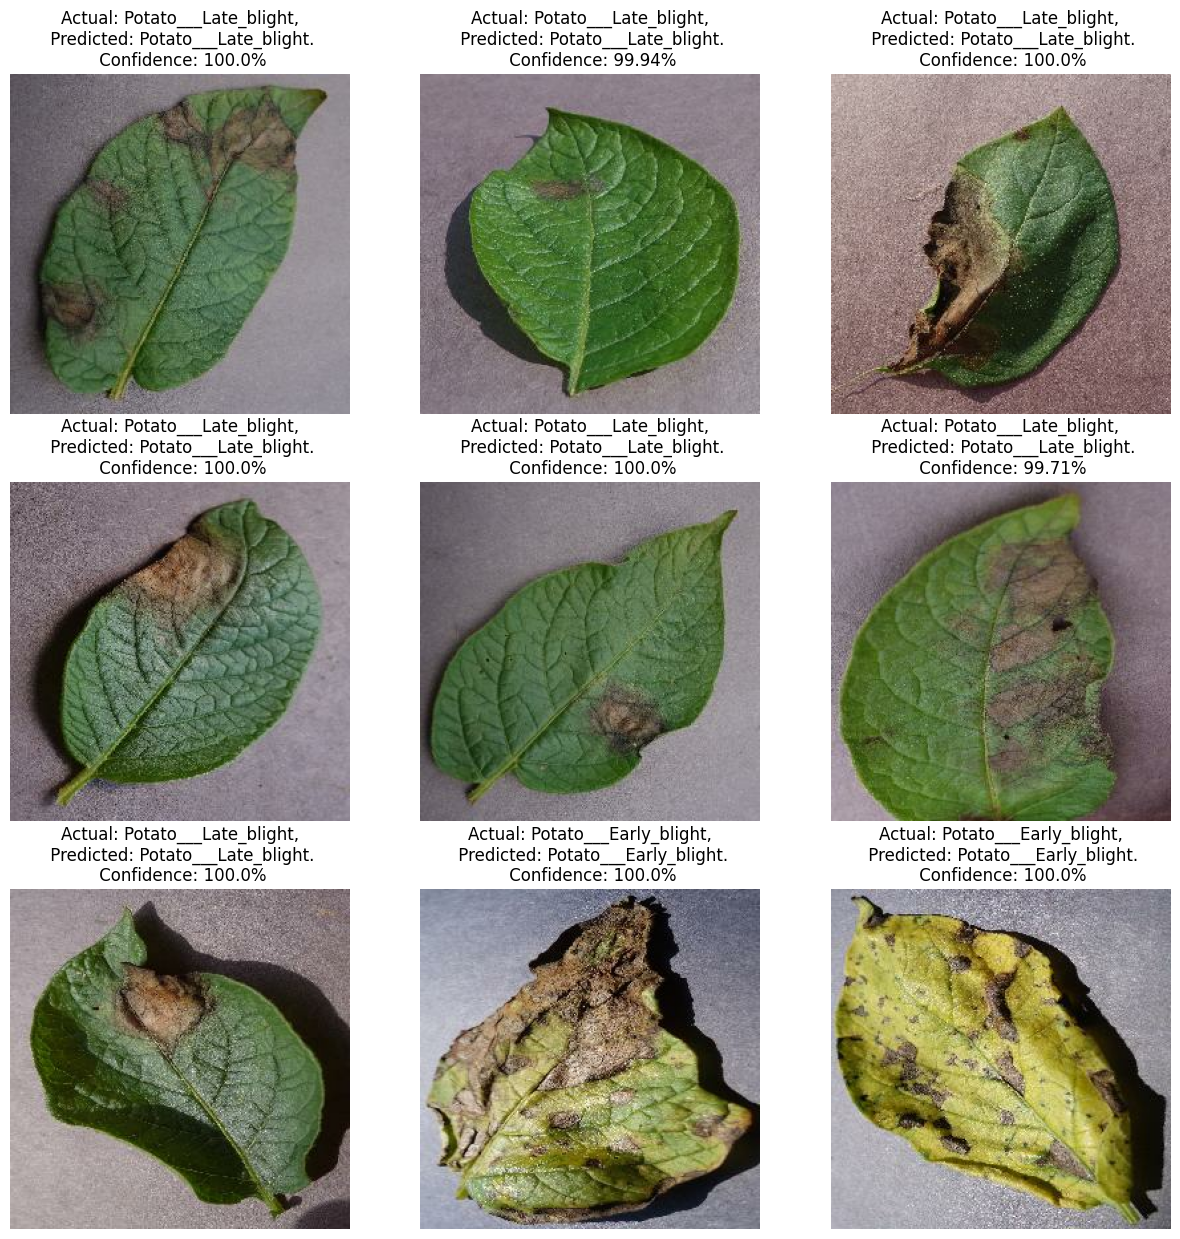

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Step 9: Saving the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define the directory path
model_dir = "/content/drive/My Drive/Colab Notebooks/Deep Learning Projects/Potato_Classification/models"
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

In [ ]:
model_version = 1

model.save(f"{model_dir}/model_v{model_version}.keras")

In [ ]:
print(f"Model saved successfully at {model_dir}/model_v{model_version}.keras")

Model saved successfully at /content/drive/My Drive/Colab Notebooks/Deep Learning Projects/Potato_Classification/models/model_v1.keras
